## Story - 7 : Where Do Strategic Minerals Come From?

#### Instructions
The US Geological Survey publishes a list of Strategic Minerals ( https://www.usgs.gov/news/national-news-release/us-geological-survey-releases-2022-list-critical-minerals ). Having a secure supply of these minerals is essential to our security and economic prosperity. However many of these minerals are sourced from outside of the US. This assignment is to develop a reference catalog of the source or sources of each of these minerals and a judgement on the reliability of each source under stressed circumstance (e.g. war, economic crisis, etc.)

#### Notes:
- You will need to identify a source or sources for each of the minerals in the 2022 List of Critical Minerals
- You will need to categorize each source country as an ally, a competitor or a neutral party.
- You will need to develop data visualizations that tell the story of source dependency and shortfall impact.
- This assignment is due at the end of week fourteen of the semester

In [1]:
import io
import zipfile
import requests
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, FuncFormatter, PercentFormatter
import numpy as np

In [2]:
pd.options.display.max_rows=3000

#### Pulling in the relevant data 


In [3]:
## First the list provided (2022 Mineral List )
critical_minerals_2022 = [
    "Aluminum",
    "Antimony",
    "Arsenic",
    "Barite",
    "Beryllium",
    "Bismuth",
    "Cerium",
    "Cesium",
    "Chromium",
    "Cobalt",
    "Dysprosium",
    "Erbium",
    "Europium",
    "Fluorspar",
    "Gadolinium",
    "Gallium",
    "Germanium",
    "Graphite",
    "Hafnium",
    "Holmium",
    "Indium",
    "Iridium",
    "Lanthanum",
    "Lithium",
    "Lutetium",
    "Magnesium",
    "Manganese",
    "Neodymium",
    "Nickel",
    "Niobium",
    "Palladium",
    "Platinum",
    "Praseodymium",
    "Rhodium",
    "Rubidium",
    "Ruthenium",
    "Samarium",
    "Scandium",
    "Tantalum",
    "Tellurium",
    "Terbium",
    "Thulium",
    "Tin",
    "Titanium",
    "Tungsten",
    "Vanadium",
    "Ytterbium",
    "Yttrium",
    "Zinc",
    "Zirconium",
]


In [4]:
#Pulling in USGS Consumption and Production Data for Minerals 
# (https://pubs.usgs.gov/publication/ofr20251047)
# https://www.sciencebase.gov/catalog/item/6899fa60d4be02504d348b4f
cons_url = "https://www.sciencebase.gov/catalog/file/get/6899fa60d4be02504d348b4f?f=__disk__0a%2F79%2Fa2%2F0a79a20f37b7cf33fd4c8fc62cfc8d3d86e1f0af"
prod_url = "https://www.sciencebase.gov/catalog/file/get/6899fa60d4be02504d348b4f?f=__disk__86%2F1e%2Fd0%2F861ed0834afd754a86c7b0da9fcb86a7e7d22a3b"

cons = pd.read_csv(cons_url, encoding="latin1")
prod = pd.read_csv(prod_url, encoding="latin1")

print(cons.head())
# print(prod.head())


  COMMODITY     COMMODITY_FORM FORM_NOTES                COUNTRY  \
0  Aluminum  Aluminum products     <null>  Canada, United States   
1  Aluminum  Aluminum products     <null>  Canada, United States   
2  Aluminum  Aluminum products     <null>  Canada, United States   
3  Aluminum  Aluminum products     <null>  Canada, United States   
4  Aluminum  Aluminum products     <null>  Canada, United States   

            END_USE_CATEGORY END_USE_NOTES  STATISTIC  YEAR QUANTITY  \
0  Building and construction        <null>  Shipments  2021    1,560   
1  Building and construction        <null>  Shipments  2022    1,590   
2          Consumer durables        <null>  Shipments  2021      870   
3          Consumer durables        <null>  Shipments  2022      865   
4   Containers and packaging        <null>  Shipments  2021    2,430   

                  UNITS STATISTIC_NOTES                DATA_SOURCE  \
0  Thousand metric tons        Revised.  MYB_2022_Aluminum_Table06   
1  Thousand metric

In [5]:
## limiting to the same year as the intitial List, Limiting to where the Consumption Country is ONLY the united states(not canada) 

## Aggregating up to the Minderal levelr and the unit level (Controlling for Mica Statistic Entry (only consumption stat)
cons_us_2022 = cons[((cons['YEAR']==2022)
                     &(cons["COUNTRY"]=='United States')
                     &((cons['COMMODITY']!='Mica')|((cons['COMMODITY']=='Mica')&(cons["STATISTIC"]=="Consumption")))
                     &((cons['COMMODITY']!='Titanium')|((cons['COMMODITY']=='Titanium')&(cons["STATISTIC"]!="Shipments")))
                    )]
cons_us_2022["QUANTITY"] = (cons_us_2022["QUANTITY"].replace("W", np.nan).astype(str).str.replace(",", "", regex=False).str.strip())
cons_us_2022["QUANTITY"] = (pd.to_numeric(cons_us_2022["QUANTITY"], errors="coerce").fillna(0).astype(float))
consumpt_2022_ua_ag = cons_us_2022.groupby(["COMMODITY","STATISTIC","UNITS"]).agg({"QUANTITY":'sum'}).reset_index()
## Converting the units as needed. 
# consumpt_2022_ua_ag["UNITS"].unique()
factor_by_unit = {
    'Metric tons': 1.0,
    'Metric tons, antimony content': 1.0,
    'Thousand metric tons': 1000.0,
    'Thousand metric tons, dry equivalent': 1000.0,
    'Kilograms': 1/1000,
    'Metric tons, chromium content': 1.0,
    'Metric tons, cobalt content': 1.0,
    'Kilograms, gallium content': 1/1000,
    'Metric tons, lead content': 1.0,
    'Kilograms, molybdenum content': 1/1000,
    'Metric tons, nickel content': 1.0,
    'Metric tons, niobium content': 1.0,
    'Metric tons, tin content': 1.0,
    'Metric tons, titanium dioxide (TiO2) content': 1.0,
    'Kilograms, vanadium content': 1/1000,
}

# metric tons calc
consumpt_2022_ua_ag["QUANTITY_metric_tons"] = (
    consumpt_2022_ua_ag["QUANTITY"] * consumpt_2022_ua_ag["UNITS"].map(factor_by_unit)
)
consumpt_2022_ua_ag["UNITS_standardized"] = "Metric tons"

## Limting to one Stat Type per mineral for a gross number that is safe. 
consumpt_2022_ua_ag = consumpt_2022_ua_ag[((consumpt_2022_ua_ag["COMMODITY"]!="Feldspar")|((consumpt_2022_ua_ag["COMMODITY"]=="Feldspar")&(consumpt_2022_ua_ag["STATISTIC"]=="Consumption")))]
consumpt_2022_ua_ag= consumpt_2022_ua_ag[((consumpt_2022_ua_ag["COMMODITY"]!="Titanium")|((consumpt_2022_ua_ag["COMMODITY"]=="Titanium")&(consumpt_2022_ua_ag["STATISTIC"]=="Consumption")))]
consumpt_2022_ua_ag = consumpt_2022_ua_ag[((consumpt_2022_ua_ag["COMMODITY"]!="Barite")|((consumpt_2022_ua_ag["COMMODITY"]=="Barite")&(consumpt_2022_ua_ag["STATISTIC"]=="Consumption (imports)")))]
consumpt_2022_ua_ag = consumpt_2022_ua_ag[consumpt_2022_ua_ag["STATISTIC"]!="Shipments"]

consumed_us_2022_fnl = consumpt_2022_ua_ag[["COMMODITY","STATISTIC","QUANTITY_metric_tons"]].rename(columns={"QUANTITY_metric_tons":"METRIC_TONS_CONSUMED"})


C:\Users\johnf\AppData\Local\Temp\ipykernel_127748\696240112.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cons_us_2022["QUANTITY"] = (cons_us_2022["QUANTITY"].replace("W", np.nan).astype(str).str.replace(",", "", regex=False).str.strip())
C:\Users\johnf\AppData\Local\Temp\ipykernel_127748\696240112.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cons_us_2022["QUANTITY"] = (pd.to_numeric(cons_us_2022["QUANTITY"], errors="coerce").fillna(0).astype(float))


In [6]:
consumed_us_2022_fnl

,COMMODITY,STATISTIC,METRIC_TONS_CONSUMED
0,Aluminum,Consumption,21284960.00
1,Antimony,Consumption (reported),33842.00
2,Barite,Consumption (imports),4654100.00
4,Bauxite and Alumina,Consumption,4333000.00
5,Bismuth,Consumption,893.00
6,Chromium,Consumption (reported),551221.00
7,Cobalt,Consumption,30275.00
8,Feldspar,Consumption,276000.00
10,Fluorspar,Consumption,1063500.00
11,Gallium,Consumption,39.43


In [7]:
## Production Data 
# prod_2022["STATISTIC"].unique() ## Only "Prodcution" in df 
# limiting to year and 
prod_2022 = prod[prod["YEAR"]==2022]
prod_2022["QUANTITY"] = pd.to_numeric(prod_2022["QUANTITY"], errors="coerce").fillna(0)
production = prod_2022.groupby(["COMMODITY","COUNTRY","STATISTIC","UNITS"]).agg({"QUANTITY":"sum"}).reset_index()
production = production[production["QUANTITY"]>0]

## Conversions to metric tons 
unit_factor_to_mt_prod = {
    "Thousand metric tons": 1000.0,

    "Metric tons, antimony content of antimony ore and concentrate, lead concentrates, and lead-zinc concentrates": 1.0,
    "Metric tons, antimony content": 1.0,
    "Metric tons, gross weight": 1.0,
    "Metric tons": 1.0,
    "Metric tons, cobalt content": 1.0,
    "Metric tons, lead content": 1.0,
    "Metric tons, lithium content": 1.0,
    "Metric tons, molybdenum content": 1.0,
    "Metric tons, nickel content": 1.0,
    "Metric tons, niobium content": 1.0,
    "Metric tons, rare-earth oxide equivalent": 1.0,
    "Metric tons, tantalum content": 1.0,
    "Metric tons, tin content": 1.0,

    "Kilograms": 1.0 / 1000.0,
    "Kilograms, rhenium content": 1.0 / 1000.0,

    "Thousand metric tons, iron content": 1000.0,
    "Thousand metric tons, potassium oxide (K2O) equivalent": 1000.0,
    "Thousand metric tons, gross weight": 1000.0,
    "Thousand metric tons, zinc content of concentrate and direct shipping ore": 1000.0,

    # Can't convert volume to mass without density -> leave as NaN and filter out
    "Million cubic meters": np.nan,
}

# assuming production["QUANTITY_NUM"] is your cleaned numeric quantity
production["factor_to_mt"] = production["UNITS"].map(unit_factor_to_mt_prod)
prod_converted= production[production["factor_to_mt"].notna()].copy()
prod_converted["QUANTITY_metric_tons"] = (prod_converted["QUANTITY"] * prod_converted["factor_to_mt"])
world_prod_22_fnl = prod_converted[["COMMODITY","COUNTRY","QUANTITY_metric_tons"]].rename(columns={"QUANTITY_metric_tons":"METRIC_TONS_PRODUCED"})
world_prod_22_fnl = world_prod_22_fnl.groupby(["COMMODITY","COUNTRY"]).agg({"METRIC_TONS_PRODUCED":"sum"}).reset_index()
world_prod_22_fnl.head()

C:\Users\johnf\AppData\Local\Temp\ipykernel_127748\2990965732.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prod_2022["QUANTITY"] = pd.to_numeric(prod_2022["QUANTITY"], errors="coerce").fillna(0)


,COMMODITY,COUNTRY,METRIC_TONS_PRODUCED
0,Aluminum,Argentina,410000.0
1,Aluminum,Azerbaijan,30000.0
2,Aluminum,Brazil,811000.0
3,Aluminum,Cameroon,40000.0
4,Aluminum,Egypt,280000.0


In [8]:
### Country Relatinoship Dict 
## Non NATO Allies https://www.state.gov/major-non-nato-ally-status
non_nato_allies = ["Argentina","Australia","Bahrain","Brazil","Colombia","Egypt","Israel", "Japan", "Jordan", "Kenya",  "Kuwait", "Morocco",
                   "New Zealand", "Pakistan","Philippines", "Qatar","South Korea","Thailand", "Tunisia",]
## Nato Allies https://www.nato.int/en/about-us/organization/nato-member-countries
nato = [ "Albania","Belgium","Bulgaria","Canada","Croatia","Czechia","Denmark","Estonia","Finland","France","Germany","Greece","Hungary",
           "Iceland","Italy","Latvia","Lithuania","Luxembourg","Montenegro","North Macedonia","Norway","Poland","Portugal","Romania",
        "Slovakia", "Slovenia", "Spain","Sweden","The Netherlands","Türkiye","United Kingdom", "United States",
]
# Adversaies https://www.ecfr.gov/current/title-15/subtitle-B/chapter-VII/subchapter-E/part-791/subpart-A/section-791.4
adversaries = ["China","Cuba","Iran","North Korea", "Russia", "Venezuela"]

ally_nato = set(nato)
ally_non_nato = set(non_nato_allies)
adv = set(adversaries)

def classify_us_relation(country: str) -> str:
    # Clean up just in case
    if pd.isna(country):
        return "Neutral"
    c = country.strip()

    # Adversary takes precedence if there is ever overlap
    if c in adv:
        return "Adversary"
    if (c in ally_nato) or (c in ally_non_nato):
        if c =='United States':
            return "Self"
        else:
            return "Ally"
    return "Neutral"


In [9]:
world_prod_22_fnl["US_RELATION"] = (world_prod_22_fnl["COUNTRY"].apply(classify_us_relation))

In [10]:
us_prod = world_prod_22_fnl[world_prod_22_fnl["COUNTRY"]=='United States']
# world_prod_22_fnl["COUNTRY"].uniquie
# us_prod

In [11]:
# Prod and Consumption in one
combo = consumed_us_2022_fnl[["COMMODITY", "METRIC_TONS_CONSUMED"]].merge(us_prod[["COMMODITY", "METRIC_TONS_PRODUCED"]],
                                                                          on="COMMODITY",
                                                                          how="outer")
combo["METRIC_TONS_PRODUCED"] = combo["METRIC_TONS_PRODUCED"].fillna(0)
combo["METRIC_TONS_CONSUMED"] = combo["METRIC_TONS_CONSUMED"].fillna(0)
combo = combo.sort_values("METRIC_TONS_CONSUMED", ascending=False).reset_index(drop=True)

### Viz 1 - What the US Consumes                                                                                                                                                                                                    
                                                                                                                                                                                                                  

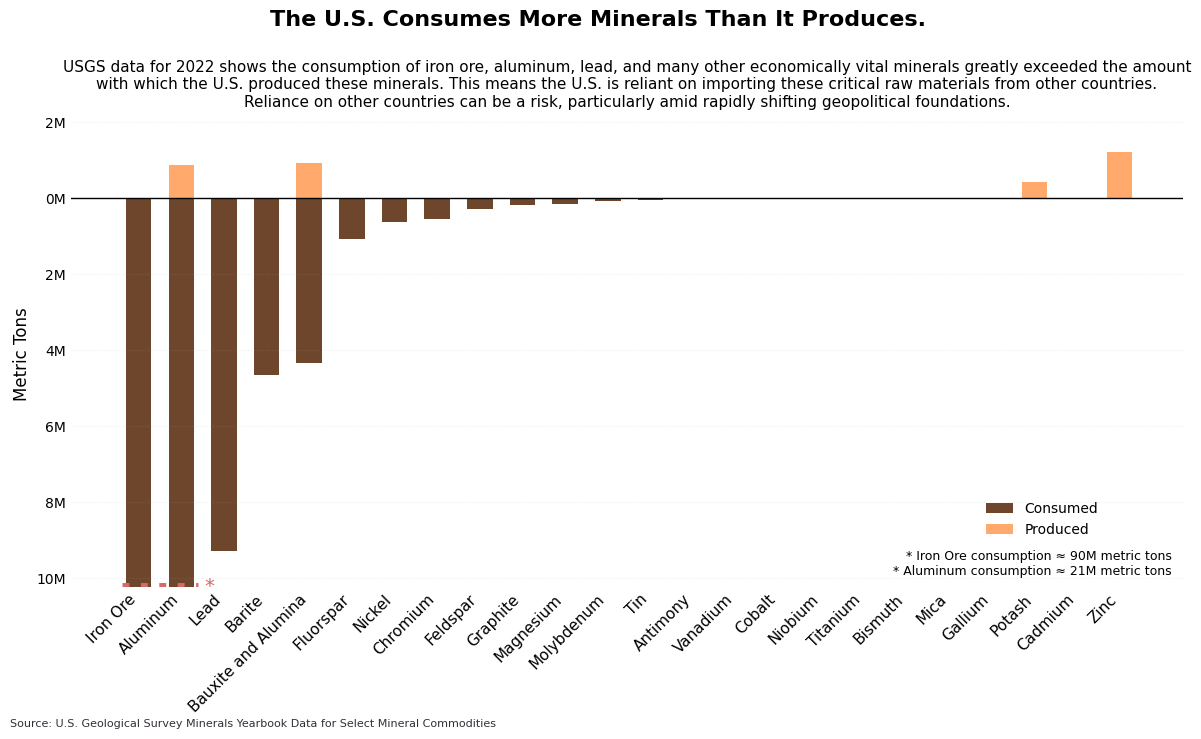

In [12]:
x       = np.arange(len(combo))
labels  = combo["COMMODITY"].values
cons    = combo["METRIC_TONS_CONSUMED"].values
prod    = combo["METRIC_TONS_PRODUCED"].values

# consump neg / bottom
cons_neg = -cons
prod_pos =  prod

# Top 2 are too big for normal setting, cutting off (Iron Ore, Aluminum)
n_outliers   = 2
outlier_mask = combo.index < n_outliers
non_out_mask = ~outlier_mask

# Editign Consumption Axis
non_out_max = float(cons[non_out_mask].max())
cutoff_val  = 10_000_000 
neg_limit   = max(non_out_max * 1.1, cutoff_val)

# Editing Production Axis
orig_pos_limit = float(prod_pos.max()) * 1.2
pos_limit      = max(orig_pos_limit, neg_limit / 5.0)

fig, ax = plt.subplots(figsize=(12, 8))

# Colors (dark = consumed, light = produced)
cmap        = plt.cm.copper
cons_color  = cmap(0.35)
prod_color  = cmap(0.85)

# Bars
width = 0.6
ax.bar(x, cons_neg, width=width, color=cons_color, label="Consumed")
ax.bar(x, prod_pos, width=width, color=prod_color, label="Produced")

# Minerals 45deg
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha="right", fontsize=11)

# Asymmetric y-limits
ax.set_ylim(-neg_limit, pos_limit)

# millions with "M" instead of Zeros
fmt = FuncFormatter(lambda y, pos: f"{abs(y)/1e6:.0f}M")
ax.yaxis.set_major_formatter(fmt)
ax.set_ylabel("Metric Tons", fontsize=12)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.axhline(0, color="black", linewidth=1)
ax.grid(axis="y", linestyle=":", alpha=0.2)
ax.tick_params(axis="x", length=0)
ax.tick_params(axis="y", length=0, labelsize=10)
outlier_lines = []
bottom, top = ax.get_ylim()
outlier_indices = np.where(outlier_mask)[0]

if len(outlier_indices) > 0:
    for idx in outlier_indices:
        name  = labels[idx]
        c_val = cons[idx]  # positive consumption
        ax.text(idx, bottom, "*", ha="center", va="bottom",fontsize=14, color=cons_color)
        outlier_lines.append(f"* {name} consumption ≈ {c_val/1e6:.0f}M metric tons")
    x_min = outlier_indices.min() - 0.4
    x_max = outlier_indices.max() + 0.4
    cut_y = bottom + 0.001 * (top - bottom) 
    ax.hlines(cut_y,x_min,x_max,colors="#d46a6a", linestyles="dotted",linewidth=5)
    ax.text(x_max + 0.15,cut_y,"*",ha="left",va="center",fontsize=14,color="#d46a6a",)

if outlier_lines:
    note = "\n".join(outlier_lines)
    ax.text(0.99, 0.02, note,transform=ax.transAxes,ha="right", va="bottom",fontsize=9,)
ax.legend(frameon=False,fontsize=10,loc="lower right",bbox_to_anchor=(0.935, 0.08),)
plt.suptitle("The U.S. Consumes More Minerals Than It Produces.",
             fontsize=16,
             fontweight="bold",
             y=0.9,)
ax.set_title(
    "USGS data for 2022 shows the consumption of iron ore, aluminum, lead, and many other economically vital minerals greatly exceeded the amount\n"
    "with which the U.S. produced these minerals. This means the U.S. is reliant on importing these critical raw materials from other countries.\n"
    "Reliance on other countries can be a risk, particularly amid rapidly shifting geopolitical foundations.",
    fontsize=11,
    pad=10,
)
fig.text(
    0.01,
    0.001,
    "Source: U.S. Geological Survey Minerals Yearbook Data for Select Mineral Commodities",
    ha="left",
    va="bottom",
    fontsize=8,
    color= "#342E37"  ,)

plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()


In [13]:
# Calculating the consuption levels taking away the 
combo["Consumption_Minus_Production"] = combo["METRIC_TONS_CONSUMED"]-combo["METRIC_TONS_PRODUCED"]
# Taking top ten ecnomically vital minrals by consuption levels
# top_10_combo = combo.sort_values(by=["Consumption_Minus_Production"], ascending=False).head(n=10)
# top_10_combo

In [14]:
world_prod_sum = world_prod_22_fnl.groupby(["COMMODITY"]).agg({"METRIC_TONS_PRODUCED":"sum"}).reset_index().rename(columns={"METRIC_TONS_PRODUCED":"GLOBAL_PROD_TOTAL_MT"})
# [world_prod_22_fnl["US_RELATION"]!='Self'
relation_grouped = world_prod_22_fnl.groupby(["COMMODITY","US_RELATION"]).agg({"METRIC_TONS_PRODUCED":"sum"}).reset_index()
world_prod_rel_pct = relation_grouped.merge(world_prod_sum, how="left", on=['COMMODITY'])
world_prod_rel_pct["Percentage_Relation_Prod"] = round((world_prod_rel_pct["METRIC_TONS_PRODUCED"]/world_prod_rel_pct["GLOBAL_PROD_TOTAL_MT"])*100,2)
world_prod_rel_pct = world_prod_rel_pct[["COMMODITY","US_RELATION","Percentage_Relation_Prod"]].sort_values(by=["COMMODITY","Percentage_Relation_Prod"])
# world_prod_rel_pct


In [15]:
df = world_prod_rel_pct.copy()

# Make sure percentage column is numeric just in case
df["Percentage_Relation_Prod"] = pd.to_numeric(
    df["Percentage_Relation_Prod"], errors="coerce"
)

# Pivot so each commodity is one row and each relation is a column
rel_by_commodity = df.pivot_table(
    index="COMMODITY",
    columns="US_RELATION",
    values="Percentage_Relation_Prod",
    aggfunc="sum",
    fill_value=0
)

In [16]:
temp = rel_by_commodity.sort_values(by=["Adversary","Neutral"],ascending=False).reset_index()
order_map = {c: i for i, c in enumerate(temp["COMMODITY"])}
world_sorted = (world_prod_rel_pct.assign(sort_key=lambda d: d["COMMODITY"].map(order_map)).sort_values(["sort_key", "US_RELATION"])
        .drop(columns="sort_key"))

### Viz 2: Who Produces What

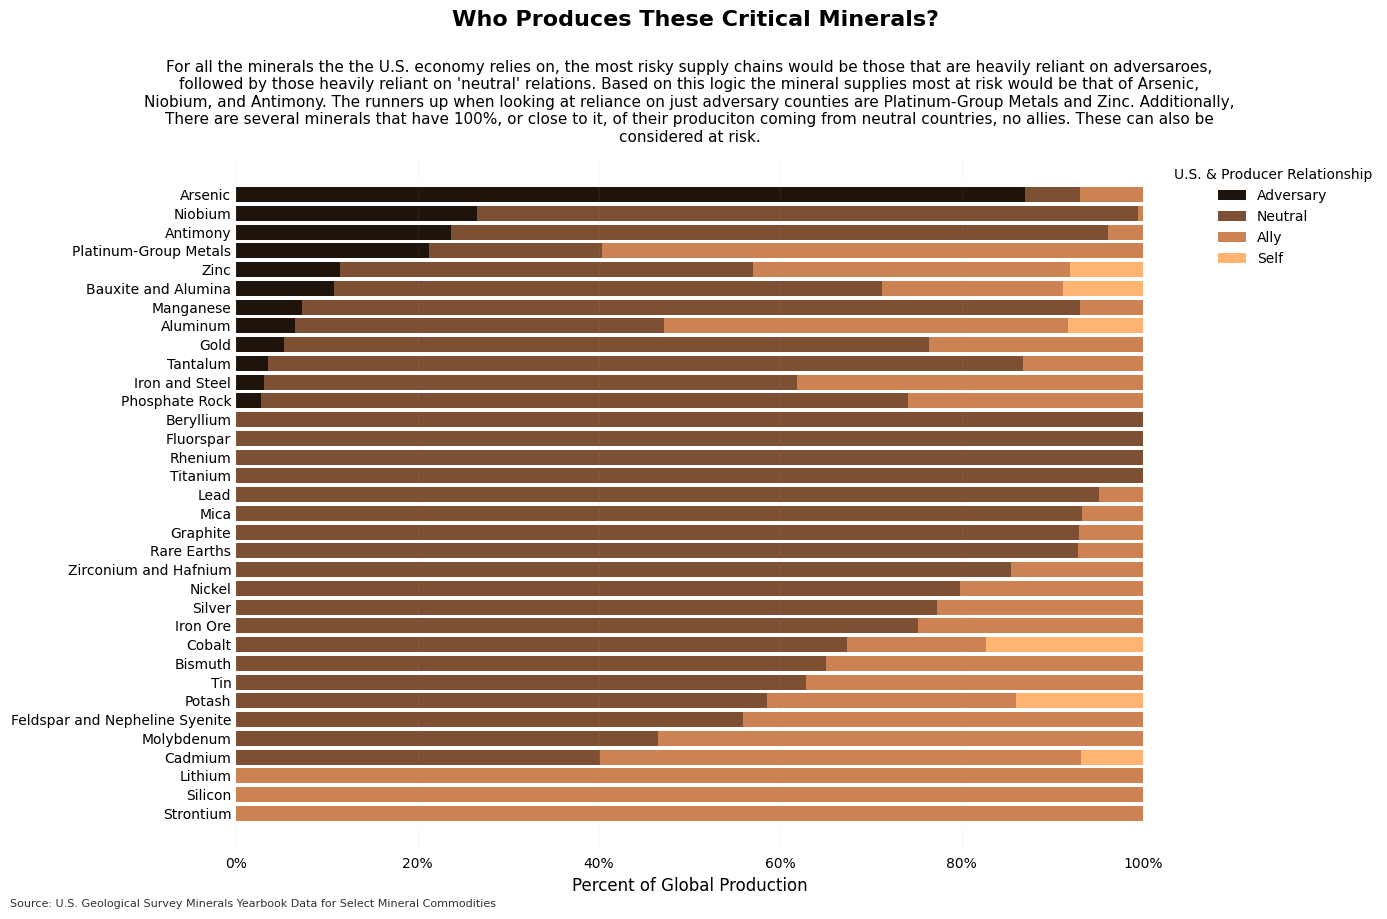

In [37]:
df = world_sorted.copy()
df["Percentage_Relation_Prod"] = pd.to_numeric(df["Percentage_Relation_Prod"], errors="coerce")

pivot = df.pivot_table(
    index="COMMODITY",
    columns="US_RELATION",
    values="Percentage_Relation_Prod",
    aggfunc="sum",
    fill_value=0,
)
sort_df = pivot[["Adversary", "Neutral"]].copy()
sort_df["AdvPlusNeutral"] = sort_df["Adversary"] + sort_df["Neutral"]
sort_order = sort_df.sort_values(
    by=["Adversary", "AdvPlusNeutral"],
    ascending=[False, False]
).index

pivot = pivot.loc[sort_order]

# order of segments in the stack
rel_order = ["Adversary", "Neutral", "Ally", "Self"]
rel_order = [r for r in rel_order if r in pivot.columns]

# ----- metallic / earthy color theme -----
cmap = plt.cm.copper  # same family as your other chart

color_map = {
    # darkest, most threatening
    "Adversary": cmap(0.10),  # deep, dark copper / bronze
    # mid earthy tone
    "Neutral":   cmap(0.40),  # warm, muted copper
    # lighter, friendly
    "Ally":      cmap(0.65),  # lighter bronze
    # lightest, almost sand/metallic highlight
    "Self":      cmap(0.90),  # pale copper / champagne
}

# ----- plotting -----
fig, ax = plt.subplots(figsize=(14, 10))

y = np.arange(len(pivot.index))
left = np.zeros(len(pivot.index))

for rel in rel_order:
    vals = pivot[rel].values
    ax.barh(
        y,
        vals,
        left=left,
        color=color_map.get(rel, None),
        label=rel,
        height=0.8,
    )
    left += vals

ax.set_yticks(y)
ax.set_yticklabels(pivot.index, fontsize=10)
ax.invert_yaxis()
ax.set_xlim(0, 100)
ax.xaxis.set_major_formatter(PercentFormatter(100))
ax.set_xlabel("Percent of Global Production", fontsize=12)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(axis="x", linestyle=":", alpha=0.2)
ax.tick_params(axis="y", length=0)
ax.tick_params(axis="x", length=0, labelsize=10)

ax.legend(
    title="U.S. & Producer Relationship",
    frameon=False,
    fontsize=10,
    title_fontsize=10,
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
)

plt.suptitle(
    "Who Produces These Critical Minerals?",
    fontsize=16,
    fontweight="bold",
    y=0.9,
)

ax.set_title(
    "For all the minerals the the U.S. economy relies on, the most risky supply chains would be those that are heavily reliant on adversaroes,\n"
    "followed by those heavily reliant on 'neutral' relations. Based on this logic the mineral supplies most at risk would be that of Arsenic,\n"
    "Niobium, and Antimony. The runners up when looking at reliance on just adversary counties are Platinum-Group Metals and Zinc. Additionally,\n"
    "There are several minerals that have 100%, or close to it, of their produciton coming from neutral countries, no allies. These can also be\n"
    "considered at risk.",
    fontsize=11,
    pad=10,
)
fig.text(
    0.01,
    0.001,
    "Source: U.S. Geological Survey Minerals Yearbook Data for Select Mineral Commodities",
    ha="left",
    va="bottom",
    fontsize=8,
    color= "#342E37"  ,)
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()


In [18]:
temp["Neutral_Adversary_Pct"] = temp["Adversary"] +temp["Neutral"]
temp.sort_values(by=["Neutral_Adversary_Pct"],ascending=False)
over_80 = temp[temp["Neutral_Adversary_Pct"]>=75].sort_values(by=["Neutral_Adversary_Pct"],ascending=False)

In [19]:
world_prod_sum = world_prod_22_fnl.groupby(["COMMODITY"]).agg({"METRIC_TONS_PRODUCED":"sum"}).reset_index().rename(columns={"METRIC_TONS_PRODUCED":"GLOBAL_PROD_TOTAL_MT"})
world_prod_cnty_pct = world_prod_22_fnl.groupby(["COMMODITY","COUNTRY"]).agg({"METRIC_TONS_PRODUCED":"sum"}).reset_index()
world_prod_cnty_pct = world_prod_cnty_pct.merge(world_prod_sum, how="left", on=['COMMODITY'])

world_prod_cnty_pct["Percentage_Country_Prod"] = round((world_prod_cnty_pct["METRIC_TONS_PRODUCED"]/world_prod_cnty_pct["GLOBAL_PROD_TOTAL_MT"])*100,2)
world_prod_cnty_pct = world_prod_cnty_pct[["COMMODITY","COUNTRY","Percentage_Country_Prod"]].sort_values(by=["COMMODITY","Percentage_Country_Prod"])

with_pct = world_prod_22_fnl.merge(world_prod_cnty_pct, on=["COMMODITY","COUNTRY"],how='left')
with_pct_comsump= with_pct.merge(combo[["COMMODITY","Consumption_Minus_Production"]],
                                 how='left',on=["COMMODITY"]).rename(columns={"Consumption_Minus_Production":"US_COM_CONSUMPTION"})

## Joinign with Consumption Data from US. 
target_countries_flat =  with_pct_comsump[((with_pct_comsump["COMMODITY"].isin(over_80["COMMODITY"].unique()))
                   &(with_pct_comsump["US_RELATION"].isin(["Neutral"]))
                   &(~with_pct_comsump["US_COM_CONSUMPTION"].isnull())
                    &(with_pct_comsump["US_COM_CONSUMPTION"]>0)
                 )]
target_countries_flat["PCT_OF_CONSUMPTION"] = round(((target_countries_flat["METRIC_TONS_PRODUCED"]/target_countries_flat["US_COM_CONSUMPTION"])*100),2)
# target_countries_top = target_countries_flat.groupby(["COUNTRY"]).agg({"PCT_OF_CONSUMPTION":"sum"}).reset_index().sort_values(by=["PCT_OF_CONSUMPTION"],ascending=False).head(n=6)

target_countries_flat.sort_values(by=["US_COM_CONSUMPTION","PCT_OF_CONSUMPTION"],ascending=False)
target_countries_max = target_countries_flat.groupby(["COMMODITY","US_COM_CONSUMPTION"]).agg({"Percentage_Country_Prod":"max",
                                                                                              "PCT_OF_CONSUMPTION":"sum"}).reset_index()
target_countries = target_countries_max.merge(target_countries_flat[["COMMODITY","Percentage_Country_Prod","COUNTRY"]],how='left', on=["COMMODITY","Percentage_Country_Prod"])
viz_3 = target_countries[["COMMODITY","US_COM_CONSUMPTION","COUNTRY","Percentage_Country_Prod","PCT_OF_CONSUMPTION"]].sort_values(by=["US_COM_CONSUMPTION","Percentage_Country_Prod"],ascending=False).merge(world_prod_22_fnl[["COMMODITY",	"COUNTRY","METRIC_TONS_PRODUCED"]],
                                                                              on=["COMMODITY",	"COUNTRY"],
                                                                              how='left')


C:\Users\johnf\AppData\Local\Temp\ipykernel_127748\2690922404.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_countries_flat["PCT_OF_CONSUMPTION"] = round(((target_countries_flat["METRIC_TONS_PRODUCED"]/target_countries_flat["US_COM_CONSUMPTION"])*100),2)


In [20]:
# viz_3[["COMMODITY","US_COM_CONSUMPTION","COUNTRY","Percentage_Country_Prod","PCT_OF_CONSUMPTION"]]

### Viz 3: How to improve secuirty

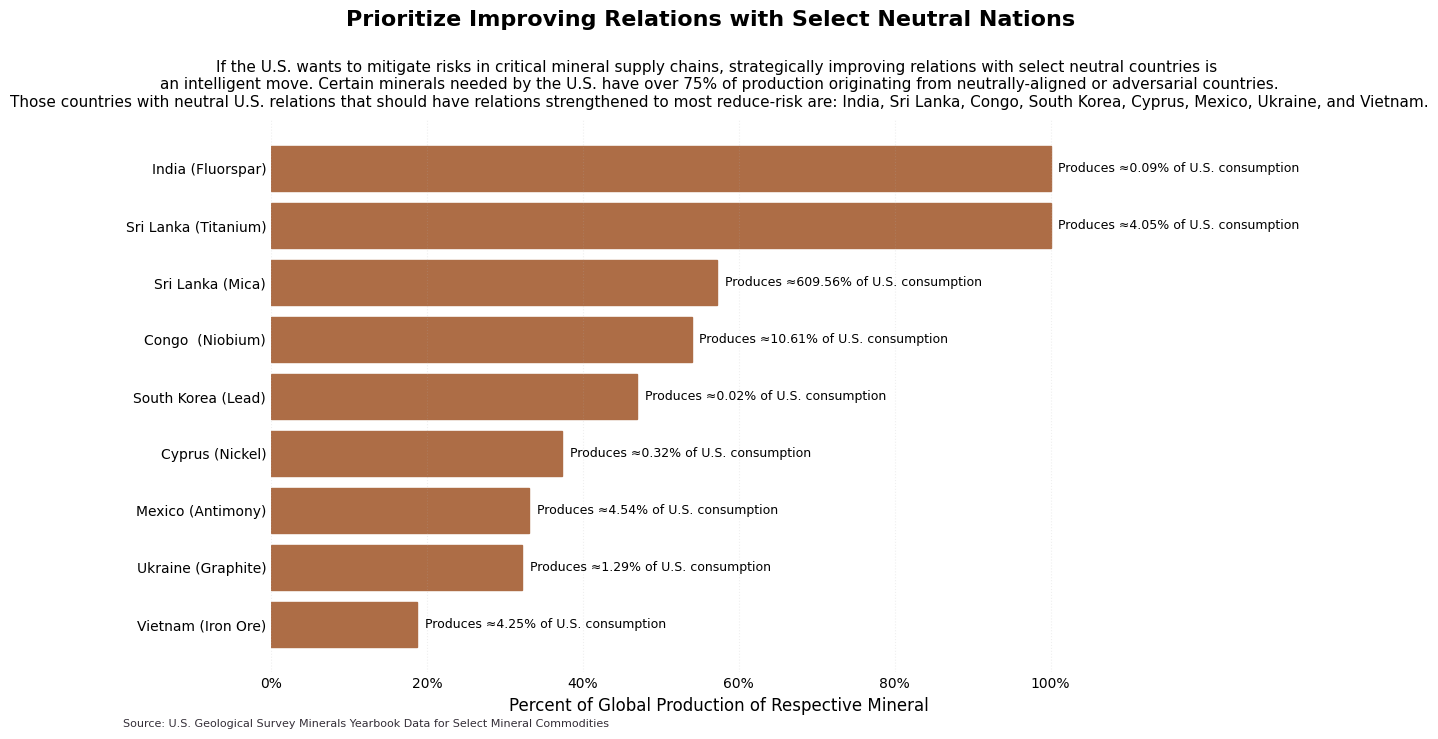

In [21]:
v3 = viz_3.copy()
v3["label"] = v3["COUNTRY"].astype(str).str.replace("(Kinshasa)","").str.replace("Korea, Republic of","South Korea") + " (" + v3["COMMODITY"]+")"
v3 = v3.sort_values("Percentage_Country_Prod", ascending=False)
y = np.arange(len(v3))
cmap = plt.cm.copper
bar_color = cmap(0.55)
edge_color = cmap(0.55)

fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.barh(
    y,
    v3["Percentage_Country_Prod"],
    color=bar_color,
    edgecolor=edge_color,
    height=0.8,
)

ax.set_yticks(y)
ax.set_yticklabels(v3["label"], fontsize=10)
ax.invert_yaxis()
ax.set_xlim(0, max(v3["Percentage_Country_Prod"]) * 1.15)
ax.xaxis.set_major_formatter(PercentFormatter(100))
ax.set_xlabel("Percent of Global Production of Respective Mineral", fontsize=12)

# annotate: share of U.S. consumption each could cover
for bar, pct_cons in zip(bars, v3["PCT_OF_CONSUMPTION"]):
    width = bar.get_width()
    if pd.notna(pct_cons):
        ax.text(
            width + max(v3["Percentage_Country_Prod"]) * 0.01,
            bar.get_y() + bar.get_height() / 2,
            f"Produces ≈{pct_cons:.2f}% of U.S. consumption",
            va="center",
            fontsize=9,
        )

# minimalist look
for spine in ax.spines.values():
    spine.set_visible(False)

ax.grid(axis="x", linestyle=":", alpha=0.2)
ax.tick_params(axis="y", length=0)
ax.tick_params(axis="x", length=0, labelsize=10)

# titles
plt.suptitle(
    "Prioritize Improving Relations with Select Neutral Nations",
    fontsize=16,
    fontweight="bold",
    y=0.90,
)

ax.set_title(
"""If the U.S. wants to mitigate risks in critical mineral supply chains, strategically improving relations with select neutral countries is 
an intelligent move. Certain minerals needed by the U.S. have over 75% of production originating from neutrally-aligned or adversarial countries.
Those countries with neutral U.S. relations that should have relations strengthened to most reduce-risk are: India, Sri Lanka, Congo, \
South Korea, Cyprus, Mexico, Ukraine, and Vietnam.""",
    fontsize=11,
    pad=10,
)
fig.text(
    0.01,
    0.001,
    "Source: U.S. Geological Survey Minerals Yearbook Data for Select Mineral Commodities",
    ha="left",
    va="bottom",
    fontsize=8,
    color= "#342E37"  ,)
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()


In [22]:
## Viz 4 - I
viz_4
"""
Assuming no mineral is more important any another, if these countries are prioritized and converted from neutral relations ti allies,  """
viz_4

NameError: name 'viz_4' is not defined

In [26]:
viz_4 = world_prod_22_fnl.copy()
viz_4["US_RELATION"][viz_4["COUNTRY"].isin(viz_3["COUNTRY"].unique())]='Potential Ally'
world_prod_sum2 = viz_4.groupby(["COMMODITY"]).agg({"METRIC_TONS_PRODUCED":"sum"}).reset_index().rename(columns={"METRIC_TONS_PRODUCED":"GLOBAL_PROD_TOTAL_MT"})
relation_grouped2 = viz_4.groupby(["COMMODITY","US_RELATION"]).agg({"METRIC_TONS_PRODUCED":"sum"}).reset_index()
world_prod_rel_pct2 = relation_grouped2.merge(world_prod_sum, how="left", on=['COMMODITY'])
world_prod_rel_pct2["Percentage_Relation_Prod"] = round((world_prod_rel_pct2["METRIC_TONS_PRODUCED"]/world_prod_rel_pct2["GLOBAL_PROD_TOTAL_MT"])*100,2)
world_prod_rel_pct2 = world_prod_rel_pct2[["COMMODITY","US_RELATION","Percentage_Relation_Prod"]].sort_values(by=["COMMODITY","Percentage_Relation_Prod"])
df = world_prod_rel_pct2.copy()
# Make sure percentage column is numeric just in case
df["Percentage_Relation_Prod"] = pd.to_numeric(df["Percentage_Relation_Prod"], errors="coerce")
# Pivot so each commodity is one row and each relation is a column
rel_by_commodity = df.pivot_table(
    index="COMMODITY",
    columns="US_RELATION",
    values="Percentage_Relation_Prod",
    aggfunc="sum",
    fill_value=0
)
temp = rel_by_commodity.sort_values(by=["Adversary","Neutral"],ascending=False).reset_index()
order_map = {c: i for i, c in enumerate(temp["COMMODITY"])}
world_sorted2 = (world_prod_rel_pct2.assign(sort_key=lambda d: d["COMMODITY"].map(order_map)).sort_values(["sort_key", "US_RELATION"])
        .drop(columns="sort_key"))

C:\Users\johnf\AppData\Local\Temp\ipykernel_127748\2525583336.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  viz_4["US_RELATION"][viz_4["COUNTRY"].isin(viz_3["COUNTRY"].unique())]='Potential Ally'
C:\Users\johnf\AppData\Local\Temp\ipyke

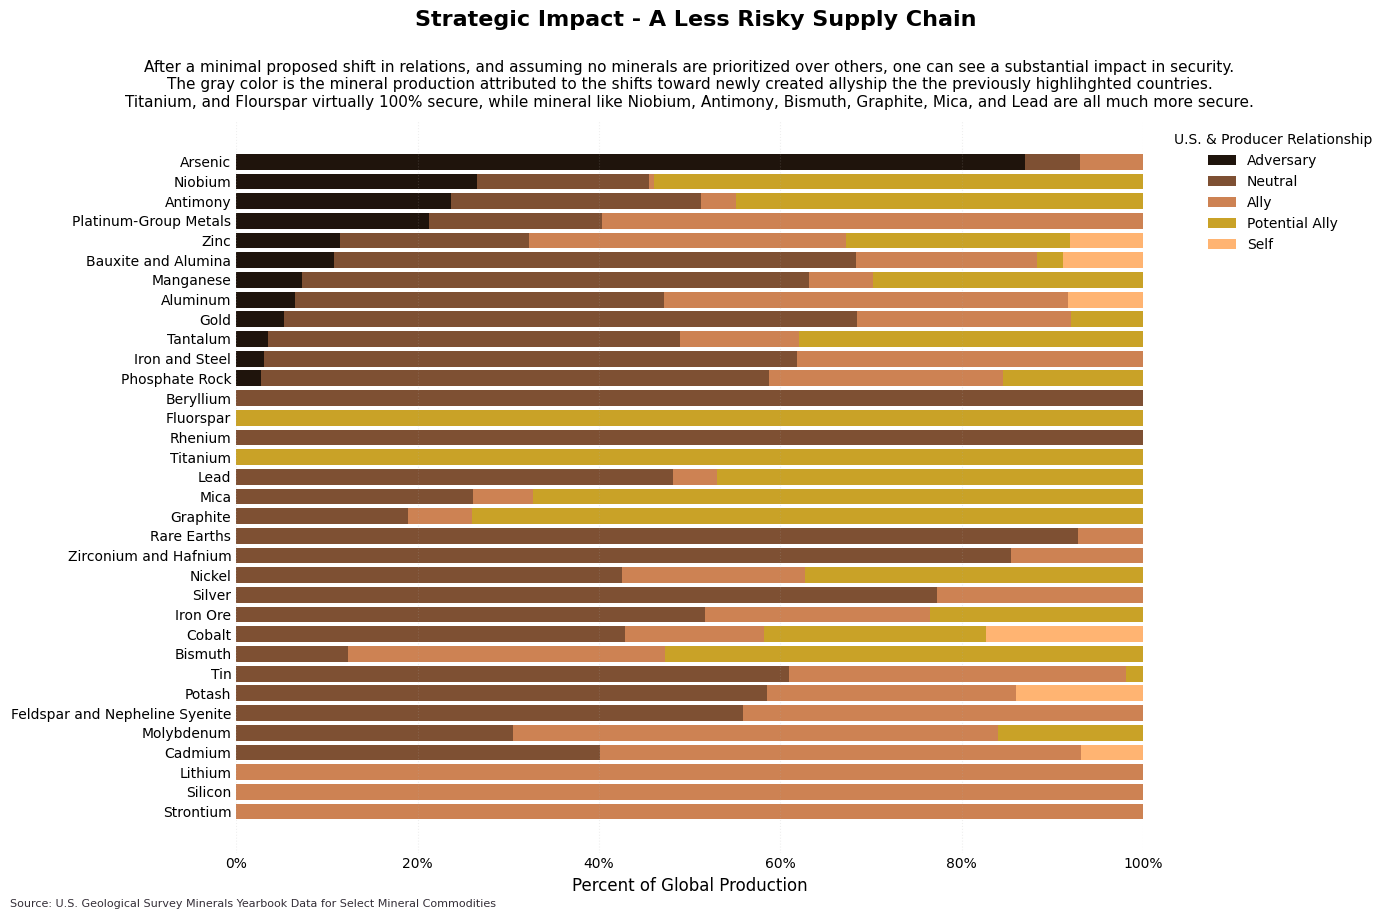

In [38]:
df = world_sorted2.copy()
df["Percentage_Relation_Prod"] = pd.to_numeric(df["Percentage_Relation_Prod"], errors="coerce")
viz2_order = sort_order
pivot = df.pivot_table(
    index="COMMODITY",
    columns="US_RELATION",
    values="Percentage_Relation_Prod",
    aggfunc="sum",
    fill_value=0,
)
sort_df = pivot[["Adversary", "Neutral"]].copy()
sort_df["AdvPlusNeutral"] = sort_df["Adversary"] + sort_df["Neutral"]
sort_order = sort_df.sort_values(
    by=["Adversary", "AdvPlusNeutral"],
    ascending=[False, False]
).index

pivot = pivot.loc[viz2_order]

# order of segments in the stack
rel_order = ["Adversary", "Neutral", "Ally","Potential Ally", "Self"]
rel_order = [r for r in rel_order if r in pivot.columns]

# ----- metallic / earthy color theme -----
cmap = plt.cm.copper  # same family as your other chart

color_map = {
    # darkest, most threatening
    "Adversary": cmap(0.10),  # deep, dark copper / bronze
    # mid earthy tone
    "Neutral":   cmap(0.40),  # warm, muted copper
    # lighter, friendly
    "Ally":      cmap(0.65),  # lighter bronze
    #  "Potential Ally"
    "Potential Ally": "#C9A227",
    # lightest, almost sand/metallic highlight
    "Self":      cmap(0.90),  # pale copper / champagne
}


# ----- plotting -----
fig, ax = plt.subplots(figsize=(14, 10))

y = np.arange(len(pivot.index))
left = np.zeros(len(pivot.index))

for rel in rel_order:
    vals = pivot[rel].values
    ax.barh(
        y,
        vals,
        left=left,
        color=color_map.get(rel, None),
        label=rel,
        height=0.8,
    )
    left += vals

ax.set_yticks(y)
ax.set_yticklabels(pivot.index, fontsize=10)
ax.invert_yaxis()
ax.set_xlim(0, 100)
ax.xaxis.set_major_formatter(PercentFormatter(100))
ax.set_xlabel("Percent of Global Production", fontsize=12)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(axis="x", linestyle=":", alpha=0.2)
ax.tick_params(axis="y", length=0)
ax.tick_params(axis="x", length=0, labelsize=10)

ax.legend(
    title="U.S. & Producer Relationship",
    frameon=False,
    fontsize=10,
    title_fontsize=10,
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
)

plt.suptitle(
    "Strategic Impact - A Less Risky Supply Chain",
    fontsize=16,
    fontweight="bold",
    y=0.9,
)

ax.set_title(
    "After a minimal proposed shift in relations, and assuming no minerals are prioritized over others, one can see a substantial impact in security.\n"
    "The gray color is the mineral production attributed to the shifts toward newly created allyship the the previously highlihghted countries.\n"
    "Titanium, and Flourspar virtually 100% secure, while mineral like Niobium, Antimony, Bismuth, Graphite, Mica, and Lead are all much more secure.",
    fontsize=11,
    pad=10,
)
fig.text(
    0.01,
    0.001,
    "Source: U.S. Geological Survey Minerals Yearbook Data for Select Mineral Commodities",
    ha="left",
    va="bottom",
    fontsize=8,
    color= "#342E37"  ,)
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()


In [35]:
pivot = pivot.loc[pivot = pivot.loc[sort_order]]

In [36]:
pivot[]

US_RELATION,Adversary,Ally,Neutral,Potential Ally,Self
COMMODITY,,,,,
Arsenic,86.96,6.96,6.09,0.00,0.00
Niobium,26.56,0.51,18.98,53.94,0.00
Antimony,23.64,3.83,27.61,44.92,0.00
Platinum-Group Metals,21.29,59.63,19.08,0.00,0.00
Zinc,11.41,34.97,20.84,24.77,8.00
Bauxite and Alumina,10.81,20.00,57.50,2.88,8.82
Manganese,7.26,6.98,55.94,29.82,0.00
Aluminum,6.53,44.54,40.66,0.00,8.28
Gold,5.23,23.59,63.25,7.93,0.00
